In [1]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
# !apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
# !pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
# !ln -s /etc/mecabrc /usr/local/etc/mecabrc
# 辞書のパス
# path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"


# pytorchのバージョン指定
!pip uninstall torch torchvision torchaudio
!pip install torchtext==0.8.1

# ライブラリのインストール
!pip install janome
!pip install japanize-matplotlib

Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.10.0+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.10.0+cu111
Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.11.1+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.7be20469.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.8313e8da.so.11
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/pyth

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
from collections import Counter
# import MeCab
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import spacy

from gensim.corpora import Dictionary
from gensim import matutils 
from glob import glob
from janome.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Pipeline
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pdb
import re

from warnings import simplefilter
simplefilter('ignore', FutureWarning)
import gc
import japanize_matplotlib
japanize_matplotlib.japanize()

root = "/content/drive/MyDrive/データ分析/dl4e/"

# デバイスを取得
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {0}".format(DEVICE))

# mecab
# mecab = MeCab.Tagger("-Owakati")

Device: cuda


In [4]:
data = pd.read_csv(root+"input/house_price.csv")

lgb_predicts_train = pd.read_csv(root+"input/lgb_predicts_train.csv")
lgb_predicts_test = pd.read_csv(root+"input/lgb_predicts_test.csv")

In [5]:
data.head(1)

,Unnamed: 0,others,target,others_add_features,others_add_features_list
0,0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、浴室乾燥機、オートロック、室...,114000.0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、浴室乾燥機、オートロック、室...,"['バストイレ別', 'バルコニー', 'エアコン', 'ガスコンロ対応', 'クロゼット'..."


In [6]:
# data = data[(data["target"] >= 60000) & (data["target"] <= 120000)]

In [7]:
train, valid = train_test_split(
    data[["others", "target"]],
    test_size=0.25, 
    shuffle=True, 
    random_state=42, 
   )

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train["target"] = train["target"] - lgb_predicts_train["predict"]
valid["target"] = valid["target"] - lgb_predicts_test["predict"]

# train["target"] = train["target"].map(lambda d: d/10000)
# valid["target"] = valid["target"].map(lambda d: d/10000)

train.to_csv(root+"output/house_price_train_lgb.csv", index=False, header=None)
valid.to_csv(root+"output/house_price_valid_lgb.csv", index=False, header=None)
# del train, valid, temp

In [8]:
train.head()

,others,target
0,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、TVインターホ...,1141.447322
1,バストイレ別、バルコニー、エアコン、クロゼット、フローリング、浴室乾燥機、オートロック、室内...,-1440.354631
2,バストイレ別、バルコニー、エアコン、ガスコンロ対応、クロゼット、フローリング、TVインターホ...,-287.685548
3,バストイレ別、バルコニー、エアコン、ガスコンロ対応、フローリング、室内洗濯置、シューズボック...,835.771511
4,エアコン、フローリング、室内洗濯置、角住戸、電気コンロ、単身者相談、冷蔵庫、敷金1ヶ月、仲手...,439.826621


In [9]:
def tokenizer(text):
    return [t for t in text.split("、")]

In [10]:
# 各種Fieldを定義
TEXT = Field(
    sequential=True, 
    tokenize=tokenizer, 
    # lower=True, 
    include_lengths=True, 
    # preprocessing=pipe, 
    # stop_words=rm
    )

# LABEL = LabelField(dtype=torch.float)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.float)


train, val = TabularDataset.splits(
    path=root+"output/", 
    train="house_price_train_lgb.csv", 
    validation="house_price_valid_lgb.csv",
    format="csv",
    fields=[("text", TEXT), ("label", LABEL)]
)

# 単語に番号を振る
# 最低出現回数をmin_freqで指定
TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

# イテレータの作成
batch_size = 256
train_iter, val_iter = BucketIterator.splits(
    (train, val), batch_size=batch_size, device=DEVICE,
    sort=False
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [11]:
class MaillOpenModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, padding_idx):
        super(MaillOpenModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.padding_idx = padding_idx
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.linear1  = nn.Linear(embedding_dim, 32)
        # self.bachnorm1 = nn.BatchNorm1d(32)
        # self.linear2  = nn.Linear(32, output_dim)
        self.linear2  = nn.Linear(32, 16)
        self.linear3 =  nn.Linear(16, output_dim)
        
        # ----- 2値分類の時
        # self.act = nn.Sigmoid()
        # -----

    def forward(self, inputs):
        # inputs = (text, text_length)
        # 入力テキストを取得
        # inputs_text = [sentence lengths, batch_size]
        inputs_text = inputs[0]
        
        # 入力をembeddingする
        # output shape: [sentence lengths, batch_size, embeddding_dim]
        embeds = self.embeddings(inputs_text)
        
        # Embeding Vectorの各次元毎 (dim=0)に和を計算し、文章のベクトルに変換する (Bag-of-Words)
        # output shape: [batch_size, embeddding_dim]
        embeds = torch.sum(embeds, dim=0) # [batch_size, embedding_dim]

        # torch.concat([""])
        
        # embeddingの結果をlinear1に入力し、出力結果に活性化関数reluを適用する
        # output shape: [batch_size, 32]
        output = F.relu(self.linear1(embeds))
        # output = F.relu(self.bachnorm1(self.linear1(embeds)))
        
        # linear1の結果をlinear2に入力する
        # output shape: [batch_size, 16]
        output = F.relu(self.linear2(output)) # [batch_size, output_dim]

        # linear2の結果をlinear3に入力する
        # output shape: [batch_size, output_dim]
        output = self.linear3(output)
        
        # ----- 2値分類のとき
        # 出力をSigmoid関数で変換して、最終出力を得る
        # output shape: [batch_size]
        # output = self.act(output.squeeze(1))
        # -----
        
        return output

In [12]:
def train_model(model, loss_function, optimizer, num_epochs=20):
    # 学習モードに設定
    model.train()

    # モデルの学習
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        for batch in tqdm(train_iter):
            optimizer.zero_grad() # 勾配の初期化
            output = model(batch.text)
            loss = loss_function(output, batch.label.float()) # 損失関数の計算
            train_loss += loss.item()  # 損失の加算
            
            # ----- 2値分類の時
            # acc = (torch.round(output) == batch.label).sum() # 正答数の数え上げ
            # train_acc += acc.item()  # 正答数の加算
            # -----

            loss.backward()  # 勾配の計算(逆伝播)
            optimizer.step()  # パラメータの更新

        avg_train_loss = train_loss / (len(train))  # 平均損失の計算

        # ----- 2値分類の時
        # avg_train_acc = train_acc / (len(train))  # 正答率の計算
        # -----

        print(('Epoch [{}/{}], train_loss: {train_loss:.5f}')
        .format(epoch+1, num_epochs, train_loss=avg_train_loss))
      
    return model

In [13]:
def evaluation(model):
    # テストデータの予測
    model.eval()  # 推論モードに切替
    mse = nn.MSELoss()
    mae = nn.L1Loss()
    
    # 計算グラフの構築をしないよう設定
    with torch.no_grad(): 
        total = 0
        valid_mse = 0
        valid_mae = 0
        cnt = 0

        for batch in tqdm(val_iter):    
            output = model(batch.text)  # 予測の計算
            valid_mse += mse(output.squeeze(), batch.label) # MSEの計算
            valid_mae += mae(output.squeeze(), batch.label) # MAEの計算
            cnt += 1

        print('\nValid MSE: {:.2f}'.format(valid_mse/cnt))
        print('Valid MAE: {:.2f}'.format(valid_mae/cnt))


In [14]:
vocab_size = len(TEXT.vocab)
embedding_dim = 16
output_dim = 1
padding_idx = TEXT.vocab.stoi["<pad>"]

# モデル定義
mailopen_model = MaillOpenModel(vocab_size, embedding_dim, output_dim, padding_idx).to(DEVICE)
loss_function = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(mailopen_model.parameters(), lr=0.001)

# モデルの学習
mailopen_model = train_model(mailopen_model, loss_function, optimizer, num_epochs=500)

# モデルの評価
evaluation(mailopen_model)

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect 

Epoch [1/500], train_loss: 134176.15930


100%|██████████| 16/16 [00:00<00:00, 181.51it/s]


Epoch [2/500], train_loss: 131767.49692


100%|██████████| 16/16 [00:00<00:00, 171.47it/s]


Epoch [3/500], train_loss: 130454.81963


100%|██████████| 16/16 [00:00<00:00, 154.19it/s]


Epoch [4/500], train_loss: 148140.39774


100%|██████████| 16/16 [00:00<00:00, 172.48it/s]


Epoch [5/500], train_loss: 133481.91161


100%|██████████| 16/16 [00:00<00:00, 178.94it/s]


Epoch [6/500], train_loss: 129744.37230


100%|██████████| 16/16 [00:00<00:00, 178.99it/s]


Epoch [7/500], train_loss: 132106.84327


100%|██████████| 16/16 [00:00<00:00, 178.70it/s]


Epoch [8/500], train_loss: 135560.67472


100%|██████████| 16/16 [00:00<00:00, 173.25it/s]


Epoch [9/500], train_loss: 131554.42600


100%|██████████| 16/16 [00:00<00:00, 185.87it/s]


Epoch [10/500], train_loss: 133244.44296


100%|██████████| 16/16 [00:00<00:00, 180.60it/s]


Epoch [11/500], train_loss: 133222.18140


100%|██████████| 16/16 [00:00<00:00, 171.68it/s]


Epoch [12/500], train_loss: 133839.82323


100%|██████████| 16/16 [00:00<00:00, 181.97it/s]


Epoch [13/500], train_loss: 133276.07348


100%|██████████| 16/16 [00:00<00:00, 179.07it/s]


Epoch [14/500], train_loss: 135072.57605


100%|██████████| 16/16 [00:00<00:00, 167.73it/s]


Epoch [15/500], train_loss: 133357.01747


100%|██████████| 16/16 [00:00<00:00, 187.57it/s]


Epoch [16/500], train_loss: 132936.97020


100%|██████████| 16/16 [00:00<00:00, 182.83it/s]


Epoch [17/500], train_loss: 138392.86588


100%|██████████| 16/16 [00:00<00:00, 168.43it/s]


Epoch [18/500], train_loss: 131356.48356


100%|██████████| 16/16 [00:00<00:00, 170.33it/s]


Epoch [19/500], train_loss: 134613.71994


100%|██████████| 16/16 [00:00<00:00, 156.11it/s]


Epoch [20/500], train_loss: 135354.42549


100%|██████████| 16/16 [00:00<00:00, 174.55it/s]


Epoch [21/500], train_loss: 135774.47276


100%|██████████| 16/16 [00:00<00:00, 159.81it/s]


Epoch [22/500], train_loss: 132146.55807


100%|██████████| 16/16 [00:00<00:00, 177.50it/s]


Epoch [23/500], train_loss: 136951.00206


100%|██████████| 16/16 [00:00<00:00, 180.03it/s]


Epoch [24/500], train_loss: 133825.47893


100%|██████████| 16/16 [00:00<00:00, 174.16it/s]


Epoch [25/500], train_loss: 134828.28726


100%|██████████| 16/16 [00:00<00:00, 169.14it/s]


Epoch [26/500], train_loss: 131202.22045


100%|██████████| 16/16 [00:00<00:00, 172.21it/s]


Epoch [27/500], train_loss: 132416.65262


100%|██████████| 16/16 [00:00<00:00, 169.06it/s]


Epoch [28/500], train_loss: 131170.05139


100%|██████████| 16/16 [00:00<00:00, 185.86it/s]


Epoch [29/500], train_loss: 133180.97688


100%|██████████| 16/16 [00:00<00:00, 180.06it/s]


Epoch [30/500], train_loss: 131724.36280


100%|██████████| 16/16 [00:00<00:00, 184.29it/s]


Epoch [31/500], train_loss: 130979.93731


100%|██████████| 16/16 [00:00<00:00, 169.46it/s]


Epoch [32/500], train_loss: 135902.71686


100%|██████████| 16/16 [00:00<00:00, 176.71it/s]


Epoch [33/500], train_loss: 132819.71788


100%|██████████| 16/16 [00:00<00:00, 182.95it/s]


Epoch [34/500], train_loss: 130425.41367


100%|██████████| 16/16 [00:00<00:00, 165.76it/s]


Epoch [35/500], train_loss: 134731.00462


100%|██████████| 16/16 [00:00<00:00, 159.79it/s]


Epoch [36/500], train_loss: 134402.32837


100%|██████████| 16/16 [00:00<00:00, 181.10it/s]


Epoch [37/500], train_loss: 131717.50976


100%|██████████| 16/16 [00:00<00:00, 170.10it/s]


Epoch [38/500], train_loss: 130602.62179


100%|██████████| 16/16 [00:00<00:00, 166.96it/s]


Epoch [39/500], train_loss: 130923.49640


100%|██████████| 16/16 [00:00<00:00, 144.66it/s]


Epoch [40/500], train_loss: 131265.45478


100%|██████████| 16/16 [00:00<00:00, 167.25it/s]


Epoch [41/500], train_loss: 130855.39003


100%|██████████| 16/16 [00:00<00:00, 164.26it/s]


Epoch [42/500], train_loss: 134500.32837


100%|██████████| 16/16 [00:00<00:00, 178.49it/s]


Epoch [43/500], train_loss: 130939.87461


100%|██████████| 16/16 [00:00<00:00, 172.35it/s]


Epoch [44/500], train_loss: 133515.06732


100%|██████████| 16/16 [00:00<00:00, 165.55it/s]


Epoch [45/500], train_loss: 134127.03751


100%|██████████| 16/16 [00:00<00:00, 178.05it/s]


Epoch [46/500], train_loss: 135904.63207


100%|██████████| 16/16 [00:00<00:00, 163.94it/s]


Epoch [47/500], train_loss: 132733.53854


100%|██████████| 16/16 [00:00<00:00, 162.61it/s]


Epoch [48/500], train_loss: 132949.52004


100%|██████████| 16/16 [00:00<00:00, 176.29it/s]


Epoch [49/500], train_loss: 131960.68140


100%|██████████| 16/16 [00:00<00:00, 163.39it/s]


Epoch [50/500], train_loss: 135578.28520


100%|██████████| 16/16 [00:00<00:00, 180.04it/s]


Epoch [51/500], train_loss: 151598.18808


100%|██████████| 16/16 [00:00<00:00, 187.88it/s]


Epoch [52/500], train_loss: 132824.75745


100%|██████████| 16/16 [00:00<00:00, 152.52it/s]


Epoch [53/500], train_loss: 133764.54265


100%|██████████| 16/16 [00:00<00:00, 172.50it/s]


Epoch [54/500], train_loss: 135095.02004


100%|██████████| 16/16 [00:00<00:00, 165.40it/s]


Epoch [55/500], train_loss: 133008.48253


100%|██████████| 16/16 [00:00<00:00, 161.82it/s]


Epoch [56/500], train_loss: 132365.01953


100%|██████████| 16/16 [00:00<00:00, 182.08it/s]


Epoch [57/500], train_loss: 136716.74409


100%|██████████| 16/16 [00:00<00:00, 170.01it/s]


Epoch [58/500], train_loss: 133764.74409


100%|██████████| 16/16 [00:00<00:00, 155.82it/s]


Epoch [59/500], train_loss: 133428.94399


100%|██████████| 16/16 [00:00<00:00, 164.31it/s]


Epoch [60/500], train_loss: 133828.47533


100%|██████████| 16/16 [00:00<00:00, 172.07it/s]


Epoch [61/500], train_loss: 132225.49794


100%|██████████| 16/16 [00:00<00:00, 163.88it/s]


Epoch [62/500], train_loss: 131223.06783


100%|██████████| 16/16 [00:00<00:00, 173.72it/s]


Epoch [63/500], train_loss: 133637.24306


100%|██████████| 16/16 [00:00<00:00, 171.18it/s]


Epoch [64/500], train_loss: 129004.90956


100%|██████████| 16/16 [00:00<00:00, 181.57it/s]


Epoch [65/500], train_loss: 134067.65365


100%|██████████| 16/16 [00:00<00:00, 171.53it/s]


Epoch [66/500], train_loss: 132703.81192


100%|██████████| 16/16 [00:00<00:00, 181.84it/s]


Epoch [67/500], train_loss: 131862.40493


100%|██████████| 16/16 [00:00<00:00, 152.99it/s]


Epoch [68/500], train_loss: 136340.52467


100%|██████████| 16/16 [00:00<00:00, 159.78it/s]


Epoch [69/500], train_loss: 137710.98356


100%|██████████| 16/16 [00:00<00:00, 182.77it/s]


Epoch [70/500], train_loss: 133639.66444


100%|██████████| 16/16 [00:00<00:00, 184.97it/s]


Epoch [71/500], train_loss: 134085.35663


100%|██████████| 16/16 [00:00<00:00, 180.94it/s]


Epoch [72/500], train_loss: 132222.37975


100%|██████████| 16/16 [00:00<00:00, 174.93it/s]


Epoch [73/500], train_loss: 131766.01028


100%|██████████| 16/16 [00:00<00:00, 166.04it/s]


Epoch [74/500], train_loss: 131106.25283


100%|██████████| 16/16 [00:00<00:00, 184.30it/s]


Epoch [75/500], train_loss: 149420.56578


100%|██████████| 16/16 [00:00<00:00, 179.41it/s]


Epoch [76/500], train_loss: 133219.41213


100%|██████████| 16/16 [00:00<00:00, 170.62it/s]


Epoch [77/500], train_loss: 134289.94861


100%|██████████| 16/16 [00:00<00:00, 153.98it/s]


Epoch [78/500], train_loss: 132951.75951


100%|██████████| 16/16 [00:00<00:00, 168.11it/s]


Epoch [79/500], train_loss: 132459.72045


100%|██████████| 16/16 [00:00<00:00, 163.19it/s]


Epoch [80/500], train_loss: 132796.84738


100%|██████████| 16/16 [00:00<00:00, 176.21it/s]


Epoch [81/500], train_loss: 135632.21429


100%|██████████| 16/16 [00:00<00:00, 184.41it/s]


Epoch [82/500], train_loss: 135982.29651


100%|██████████| 16/16 [00:00<00:00, 172.07it/s]


Epoch [83/500], train_loss: 132020.68654


100%|██████████| 16/16 [00:00<00:00, 178.86it/s]


Epoch [84/500], train_loss: 134581.31295


100%|██████████| 16/16 [00:00<00:00, 183.03it/s]


Epoch [85/500], train_loss: 133966.58273


100%|██████████| 16/16 [00:00<00:00, 177.22it/s]


Epoch [86/500], train_loss: 130430.48535


100%|██████████| 16/16 [00:00<00:00, 177.93it/s]


Epoch [87/500], train_loss: 137329.86845


100%|██████████| 16/16 [00:00<00:00, 185.88it/s]


Epoch [88/500], train_loss: 134243.70812


100%|██████████| 16/16 [00:00<00:00, 176.73it/s]


Epoch [89/500], train_loss: 131647.20709


100%|██████████| 16/16 [00:00<00:00, 174.73it/s]


Epoch [90/500], train_loss: 130535.35920


100%|██████████| 16/16 [00:00<00:00, 181.02it/s]


Epoch [91/500], train_loss: 129768.72970


100%|██████████| 16/16 [00:00<00:00, 164.56it/s]


Epoch [92/500], train_loss: 131703.23433


100%|██████████| 16/16 [00:00<00:00, 157.38it/s]


Epoch [93/500], train_loss: 133851.26105


100%|██████████| 16/16 [00:00<00:00, 150.01it/s]


Epoch [94/500], train_loss: 136386.62847


100%|██████████| 16/16 [00:00<00:00, 164.68it/s]


Epoch [95/500], train_loss: 135050.52980


100%|██████████| 16/16 [00:00<00:00, 170.07it/s]


Epoch [96/500], train_loss: 133205.49024


100%|██████████| 16/16 [00:00<00:00, 167.28it/s]


Epoch [97/500], train_loss: 138102.58839


100%|██████████| 16/16 [00:00<00:00, 174.14it/s]


Epoch [98/500], train_loss: 134841.34892


100%|██████████| 16/16 [00:00<00:00, 160.11it/s]


Epoch [99/500], train_loss: 131168.52826


100%|██████████| 16/16 [00:00<00:00, 169.03it/s]


Epoch [100/500], train_loss: 132520.82631


100%|██████████| 16/16 [00:00<00:00, 176.44it/s]


Epoch [101/500], train_loss: 134410.28263


100%|██████████| 16/16 [00:00<00:00, 153.54it/s]


Epoch [102/500], train_loss: 130885.36228


100%|██████████| 16/16 [00:00<00:00, 169.47it/s]


Epoch [103/500], train_loss: 135424.03392


100%|██████████| 16/16 [00:00<00:00, 172.09it/s]


Epoch [104/500], train_loss: 134146.80884


100%|██████████| 16/16 [00:00<00:00, 182.05it/s]


Epoch [105/500], train_loss: 136596.52569


100%|██████████| 16/16 [00:00<00:00, 179.90it/s]


Epoch [106/500], train_loss: 134266.18448


100%|██████████| 16/16 [00:00<00:00, 160.83it/s]


Epoch [107/500], train_loss: 134462.81552


100%|██████████| 16/16 [00:00<00:00, 166.35it/s]


Epoch [108/500], train_loss: 133337.77184


100%|██████████| 16/16 [00:00<00:00, 174.49it/s]


Epoch [109/500], train_loss: 129593.40468


100%|██████████| 16/16 [00:00<00:00, 177.09it/s]


Epoch [110/500], train_loss: 131844.70966


100%|██████████| 16/16 [00:00<00:00, 173.81it/s]


Epoch [111/500], train_loss: 130811.08839


100%|██████████| 16/16 [00:00<00:00, 163.22it/s]


Epoch [112/500], train_loss: 132335.18294


100%|██████████| 16/16 [00:00<00:00, 164.05it/s]


Epoch [113/500], train_loss: 132187.97636


100%|██████████| 16/16 [00:00<00:00, 168.57it/s]


Epoch [114/500], train_loss: 134051.38541


100%|██████████| 16/16 [00:00<00:00, 166.65it/s]


Epoch [115/500], train_loss: 133976.05961


100%|██████████| 16/16 [00:00<00:00, 161.12it/s]


Epoch [116/500], train_loss: 134629.02569


100%|██████████| 16/16 [00:00<00:00, 178.44it/s]


Epoch [117/500], train_loss: 133356.85252


100%|██████████| 16/16 [00:00<00:00, 183.17it/s]


Epoch [118/500], train_loss: 133816.09866


100%|██████████| 16/16 [00:00<00:00, 173.42it/s]


Epoch [119/500], train_loss: 132799.10997


100%|██████████| 16/16 [00:00<00:00, 171.74it/s]


Epoch [120/500], train_loss: 138862.53443


100%|██████████| 16/16 [00:00<00:00, 157.02it/s]


Epoch [121/500], train_loss: 133078.17266


100%|██████████| 16/16 [00:00<00:00, 152.58it/s]


Epoch [122/500], train_loss: 130438.08582


100%|██████████| 16/16 [00:00<00:00, 156.55it/s]


Epoch [123/500], train_loss: 131205.17318


100%|██████████| 16/16 [00:00<00:00, 141.61it/s]


Epoch [124/500], train_loss: 132772.76773


100%|██████████| 16/16 [00:00<00:00, 167.35it/s]


Epoch [125/500], train_loss: 135581.63052


100%|██████████| 16/16 [00:00<00:00, 167.48it/s]


Epoch [126/500], train_loss: 131573.60432


100%|██████████| 16/16 [00:00<00:00, 169.82it/s]


Epoch [127/500], train_loss: 133650.75540


100%|██████████| 16/16 [00:00<00:00, 178.69it/s]


Epoch [128/500], train_loss: 133330.71994


100%|██████████| 16/16 [00:00<00:00, 171.27it/s]


Epoch [129/500], train_loss: 135489.40442


100%|██████████| 16/16 [00:00<00:00, 166.27it/s]


Epoch [130/500], train_loss: 136199.93474


100%|██████████| 16/16 [00:00<00:00, 166.69it/s]


Epoch [131/500], train_loss: 132869.49949


100%|██████████| 16/16 [00:00<00:00, 180.40it/s]


Epoch [132/500], train_loss: 133639.44296


100%|██████████| 16/16 [00:00<00:00, 163.33it/s]


Epoch [133/500], train_loss: 136936.94142


100%|██████████| 16/16 [00:00<00:00, 161.23it/s]


Epoch [134/500], train_loss: 131722.67472


100%|██████████| 16/16 [00:00<00:00, 155.71it/s]


Epoch [135/500], train_loss: 133509.34635


100%|██████████| 16/16 [00:00<00:00, 176.27it/s]


Epoch [136/500], train_loss: 133190.16547


100%|██████████| 16/16 [00:00<00:00, 168.90it/s]


Epoch [137/500], train_loss: 133639.24923


100%|██████████| 16/16 [00:00<00:00, 171.23it/s]


Epoch [138/500], train_loss: 134695.04419


100%|██████████| 16/16 [00:00<00:00, 168.10it/s]


Epoch [139/500], train_loss: 134014.64851


100%|██████████| 16/16 [00:00<00:00, 129.60it/s]


Epoch [140/500], train_loss: 134920.13977


100%|██████████| 16/16 [00:00<00:00, 170.16it/s]


Epoch [141/500], train_loss: 136151.22097


100%|██████████| 16/16 [00:00<00:00, 184.13it/s]


Epoch [142/500], train_loss: 132015.80319


100%|██████████| 16/16 [00:00<00:00, 176.79it/s]


Epoch [143/500], train_loss: 132691.94450


100%|██████████| 16/16 [00:00<00:00, 170.00it/s]


Epoch [144/500], train_loss: 133943.89825


100%|██████████| 16/16 [00:00<00:00, 184.82it/s]


Epoch [145/500], train_loss: 134133.98613


100%|██████████| 16/16 [00:00<00:00, 166.19it/s]


Epoch [146/500], train_loss: 131276.32837


100%|██████████| 16/16 [00:00<00:00, 174.07it/s]


Epoch [147/500], train_loss: 134269.63926


100%|██████████| 16/16 [00:00<00:00, 182.39it/s]


Epoch [148/500], train_loss: 135809.24152


100%|██████████| 16/16 [00:00<00:00, 164.44it/s]


Epoch [149/500], train_loss: 131744.54933


100%|██████████| 16/16 [00:00<00:00, 179.07it/s]


Epoch [150/500], train_loss: 129924.95812


100%|██████████| 16/16 [00:00<00:00, 174.15it/s]


Epoch [151/500], train_loss: 129428.95324


100%|██████████| 16/16 [00:00<00:00, 172.71it/s]


Epoch [152/500], train_loss: 134103.81912


100%|██████████| 16/16 [00:00<00:00, 142.00it/s]


Epoch [153/500], train_loss: 134144.37975


100%|██████████| 16/16 [00:00<00:00, 169.68it/s]


Epoch [154/500], train_loss: 134828.24717


100%|██████████| 16/16 [00:00<00:00, 153.64it/s]


Epoch [155/500], train_loss: 133356.01233


100%|██████████| 16/16 [00:00<00:00, 167.48it/s]


Epoch [156/500], train_loss: 133674.14286


100%|██████████| 16/16 [00:00<00:00, 172.21it/s]


Epoch [157/500], train_loss: 131484.16084


100%|██████████| 16/16 [00:00<00:00, 166.42it/s]


Epoch [158/500], train_loss: 133735.16804


100%|██████████| 16/16 [00:00<00:00, 160.18it/s]


Epoch [159/500], train_loss: 133661.45786


100%|██████████| 16/16 [00:00<00:00, 164.09it/s]


Epoch [160/500], train_loss: 134991.20812


100%|██████████| 16/16 [00:00<00:00, 155.44it/s]


Epoch [161/500], train_loss: 133741.40853


100%|██████████| 16/16 [00:00<00:00, 164.46it/s]


Epoch [162/500], train_loss: 135923.98201


100%|██████████| 16/16 [00:00<00:00, 168.29it/s]


Epoch [163/500], train_loss: 134865.05858


100%|██████████| 16/16 [00:00<00:00, 166.49it/s]


Epoch [164/500], train_loss: 133350.14954


100%|██████████| 16/16 [00:00<00:00, 159.87it/s]


Epoch [165/500], train_loss: 133945.63464


100%|██████████| 16/16 [00:00<00:00, 177.90it/s]


Epoch [166/500], train_loss: 133311.51182


100%|██████████| 16/16 [00:00<00:00, 166.78it/s]


Epoch [167/500], train_loss: 130538.89029


100%|██████████| 16/16 [00:00<00:00, 181.14it/s]


Epoch [168/500], train_loss: 135055.28571


100%|██████████| 16/16 [00:00<00:00, 181.99it/s]


Epoch [169/500], train_loss: 133256.99538


100%|██████████| 16/16 [00:00<00:00, 177.55it/s]


Epoch [170/500], train_loss: 133323.92240


100%|██████████| 16/16 [00:00<00:00, 130.95it/s]


Epoch [171/500], train_loss: 132377.82374


100%|██████████| 16/16 [00:00<00:00, 180.82it/s]


Epoch [172/500], train_loss: 136655.15057


100%|██████████| 16/16 [00:00<00:00, 167.03it/s]


Epoch [173/500], train_loss: 134105.23998


100%|██████████| 16/16 [00:00<00:00, 175.30it/s]


Epoch [174/500], train_loss: 132394.83916


100%|██████████| 16/16 [00:00<00:00, 173.12it/s]


Epoch [175/500], train_loss: 132607.80370


100%|██████████| 16/16 [00:00<00:00, 181.97it/s]


Epoch [176/500], train_loss: 131900.29753


100%|██████████| 16/16 [00:00<00:00, 169.30it/s]


Epoch [177/500], train_loss: 133899.97328


100%|██████████| 16/16 [00:00<00:00, 167.98it/s]


Epoch [178/500], train_loss: 130325.37693


100%|██████████| 16/16 [00:00<00:00, 161.95it/s]


Epoch [179/500], train_loss: 136448.35098


100%|██████████| 16/16 [00:00<00:00, 180.11it/s]


Epoch [180/500], train_loss: 134212.69065


100%|██████████| 16/16 [00:00<00:00, 167.20it/s]


Epoch [181/500], train_loss: 132616.77390


100%|██████████| 16/16 [00:00<00:00, 175.11it/s]


Epoch [182/500], train_loss: 133267.44039


100%|██████████| 16/16 [00:00<00:00, 164.57it/s]


Epoch [183/500], train_loss: 136483.41984


100%|██████████| 16/16 [00:00<00:00, 177.31it/s]


Epoch [184/500], train_loss: 134531.75797


100%|██████████| 16/16 [00:00<00:00, 163.38it/s]


Epoch [185/500], train_loss: 133435.19681


100%|██████████| 16/16 [00:00<00:00, 170.82it/s]


Epoch [186/500], train_loss: 134058.17215


100%|██████████| 16/16 [00:00<00:00, 175.32it/s]


Epoch [187/500], train_loss: 131966.73484


100%|██████████| 16/16 [00:00<00:00, 167.79it/s]


Epoch [188/500], train_loss: 136037.16906


100%|██████████| 16/16 [00:00<00:00, 150.31it/s]


Epoch [189/500], train_loss: 135266.31141


100%|██████████| 16/16 [00:00<00:00, 161.77it/s]


Epoch [190/500], train_loss: 133088.27184


100%|██████████| 16/16 [00:00<00:00, 170.01it/s]


Epoch [191/500], train_loss: 132339.58530


100%|██████████| 16/16 [00:00<00:00, 169.19it/s]


Epoch [192/500], train_loss: 132244.18037


100%|██████████| 16/16 [00:00<00:00, 174.54it/s]


Epoch [193/500], train_loss: 131290.05807


100%|██████████| 16/16 [00:00<00:00, 171.38it/s]


Epoch [194/500], train_loss: 131981.69373


100%|██████████| 16/16 [00:00<00:00, 167.35it/s]


Epoch [195/500], train_loss: 130138.75540


100%|██████████| 16/16 [00:00<00:00, 152.80it/s]


Epoch [196/500], train_loss: 132117.88232


100%|██████████| 16/16 [00:00<00:00, 160.80it/s]


Epoch [197/500], train_loss: 134424.45940


100%|██████████| 16/16 [00:00<00:00, 179.36it/s]


Epoch [198/500], train_loss: 131310.58633


100%|██████████| 16/16 [00:00<00:00, 160.27it/s]


Epoch [199/500], train_loss: 131922.42395


100%|██████████| 16/16 [00:00<00:00, 153.76it/s]


Epoch [200/500], train_loss: 131503.58941


100%|██████████| 16/16 [00:00<00:00, 155.52it/s]


Epoch [201/500], train_loss: 133217.55807


100%|██████████| 16/16 [00:00<00:00, 168.53it/s]


Epoch [202/500], train_loss: 130664.86639


100%|██████████| 16/16 [00:00<00:00, 175.61it/s]


Epoch [203/500], train_loss: 135397.31141


100%|██████████| 16/16 [00:00<00:00, 174.06it/s]


Epoch [204/500], train_loss: 134995.83967


100%|██████████| 16/16 [00:00<00:00, 156.68it/s]


Epoch [205/500], train_loss: 129747.53032


100%|██████████| 16/16 [00:00<00:00, 161.01it/s]


Epoch [206/500], train_loss: 131812.02107


100%|██████████| 16/16 [00:00<00:00, 163.75it/s]


Epoch [207/500], train_loss: 130984.15468


100%|██████████| 16/16 [00:00<00:00, 141.36it/s]


Epoch [208/500], train_loss: 135313.57297


100%|██████████| 16/16 [00:00<00:00, 149.97it/s]


Epoch [209/500], train_loss: 133982.22456


100%|██████████| 16/16 [00:00<00:00, 134.90it/s]


Epoch [210/500], train_loss: 134180.00925


100%|██████████| 16/16 [00:00<00:00, 143.70it/s]


Epoch [211/500], train_loss: 132047.35868


100%|██████████| 16/16 [00:00<00:00, 150.55it/s]


Epoch [212/500], train_loss: 135293.30781


100%|██████████| 16/16 [00:00<00:00, 142.66it/s]


Epoch [213/500], train_loss: 130173.77415


100%|██████████| 16/16 [00:00<00:00, 145.57it/s]


Epoch [214/500], train_loss: 132295.32785


100%|██████████| 16/16 [00:00<00:00, 164.64it/s]


Epoch [215/500], train_loss: 136232.89260


100%|██████████| 16/16 [00:00<00:00, 154.65it/s]


Epoch [216/500], train_loss: 132434.88078


100%|██████████| 16/16 [00:00<00:00, 156.75it/s]


Epoch [217/500], train_loss: 133743.02261


100%|██████████| 16/16 [00:00<00:00, 144.45it/s]


Epoch [218/500], train_loss: 130329.71737


100%|██████████| 16/16 [00:00<00:00, 151.99it/s]


Epoch [219/500], train_loss: 131698.18705


100%|██████████| 16/16 [00:00<00:00, 168.30it/s]


Epoch [220/500], train_loss: 138142.16495


100%|██████████| 16/16 [00:00<00:00, 155.62it/s]


Epoch [221/500], train_loss: 136263.36948


100%|██████████| 16/16 [00:00<00:00, 150.77it/s]


Epoch [222/500], train_loss: 131495.27852


100%|██████████| 16/16 [00:00<00:00, 150.27it/s]


Epoch [223/500], train_loss: 135979.82785


100%|██████████| 16/16 [00:00<00:00, 169.22it/s]


Epoch [224/500], train_loss: 131902.14594


100%|██████████| 16/16 [00:00<00:00, 157.05it/s]


Epoch [225/500], train_loss: 133770.23124


100%|██████████| 16/16 [00:00<00:00, 166.53it/s]


Epoch [226/500], train_loss: 137470.11768


100%|██████████| 16/16 [00:00<00:00, 173.06it/s]


Epoch [227/500], train_loss: 131430.81449


100%|██████████| 16/16 [00:00<00:00, 163.92it/s]


Epoch [228/500], train_loss: 132209.01953


100%|██████████| 16/16 [00:00<00:00, 190.55it/s]


Epoch [229/500], train_loss: 135429.49794


100%|██████████| 16/16 [00:00<00:00, 174.90it/s]


Epoch [230/500], train_loss: 136411.64697


100%|██████████| 16/16 [00:00<00:00, 153.27it/s]


Epoch [231/500], train_loss: 129574.07682


100%|██████████| 16/16 [00:00<00:00, 165.65it/s]


Epoch [232/500], train_loss: 134185.91161


100%|██████████| 16/16 [00:00<00:00, 153.33it/s]


Epoch [233/500], train_loss: 130029.35714


100%|██████████| 16/16 [00:00<00:00, 168.03it/s]


Epoch [234/500], train_loss: 131271.64902


100%|██████████| 16/16 [00:00<00:00, 166.28it/s]


Epoch [235/500], train_loss: 136069.93371


100%|██████████| 16/16 [00:00<00:00, 172.14it/s]


Epoch [236/500], train_loss: 140066.90802


100%|██████████| 16/16 [00:00<00:00, 174.08it/s]


Epoch [237/500], train_loss: 131397.85406


100%|██████████| 16/16 [00:00<00:00, 169.69it/s]


Epoch [238/500], train_loss: 139592.82066


100%|██████████| 16/16 [00:00<00:00, 171.42it/s]


Epoch [239/500], train_loss: 134786.38386


100%|██████████| 16/16 [00:00<00:00, 165.13it/s]


Epoch [240/500], train_loss: 136864.28571


100%|██████████| 16/16 [00:00<00:00, 151.75it/s]


Epoch [241/500], train_loss: 135148.05704


100%|██████████| 16/16 [00:00<00:00, 139.47it/s]


Epoch [242/500], train_loss: 133998.75231


100%|██████████| 16/16 [00:00<00:00, 161.22it/s]


Epoch [243/500], train_loss: 131819.51593


100%|██████████| 16/16 [00:00<00:00, 163.10it/s]


Epoch [244/500], train_loss: 133755.68756


100%|██████████| 16/16 [00:00<00:00, 177.09it/s]


Epoch [245/500], train_loss: 136172.58171


100%|██████████| 16/16 [00:00<00:00, 168.67it/s]


Epoch [246/500], train_loss: 151937.91932


100%|██████████| 16/16 [00:00<00:00, 159.85it/s]


Epoch [247/500], train_loss: 132807.45940


100%|██████████| 16/16 [00:00<00:00, 151.60it/s]


Epoch [248/500], train_loss: 131463.19322


100%|██████████| 16/16 [00:00<00:00, 169.77it/s]


Epoch [249/500], train_loss: 135417.21994


100%|██████████| 16/16 [00:00<00:00, 144.33it/s]


Epoch [250/500], train_loss: 132497.35149


100%|██████████| 16/16 [00:00<00:00, 168.71it/s]


Epoch [251/500], train_loss: 134497.56526


100%|██████████| 16/16 [00:00<00:00, 164.14it/s]


Epoch [252/500], train_loss: 134155.64080


100%|██████████| 16/16 [00:00<00:00, 163.53it/s]


Epoch [253/500], train_loss: 132818.33967


100%|██████████| 16/16 [00:00<00:00, 166.65it/s]


Epoch [254/500], train_loss: 132376.56115


100%|██████████| 16/16 [00:00<00:00, 153.86it/s]


Epoch [255/500], train_loss: 133813.05755


100%|██████████| 16/16 [00:00<00:00, 170.47it/s]


Epoch [256/500], train_loss: 134348.82734


100%|██████████| 16/16 [00:00<00:00, 173.69it/s]


Epoch [257/500], train_loss: 134829.64697


100%|██████████| 16/16 [00:00<00:00, 179.91it/s]


Epoch [258/500], train_loss: 135357.60329


100%|██████████| 16/16 [00:00<00:00, 164.71it/s]


Epoch [259/500], train_loss: 132485.13258


100%|██████████| 16/16 [00:00<00:00, 140.25it/s]


Epoch [260/500], train_loss: 133336.76105


100%|██████████| 16/16 [00:00<00:00, 162.14it/s]


Epoch [261/500], train_loss: 130702.25283


100%|██████████| 16/16 [00:00<00:00, 157.12it/s]


Epoch [262/500], train_loss: 130239.83145


100%|██████████| 16/16 [00:00<00:00, 162.17it/s]


Epoch [263/500], train_loss: 131351.19168


100%|██████████| 16/16 [00:00<00:00, 171.71it/s]


Epoch [264/500], train_loss: 130359.97816


100%|██████████| 16/16 [00:00<00:00, 166.52it/s]


Epoch [265/500], train_loss: 133036.66752


100%|██████████| 16/16 [00:00<00:00, 163.39it/s]


Epoch [266/500], train_loss: 139971.16855


100%|██████████| 16/16 [00:00<00:00, 165.08it/s]


Epoch [267/500], train_loss: 133219.62333


100%|██████████| 16/16 [00:00<00:00, 154.48it/s]


Epoch [268/500], train_loss: 149172.94347


100%|██████████| 16/16 [00:00<00:00, 148.67it/s]


Epoch [269/500], train_loss: 139305.50617


100%|██████████| 16/16 [00:00<00:00, 159.74it/s]


Epoch [270/500], train_loss: 134199.92446


100%|██████████| 16/16 [00:00<00:00, 170.81it/s]


Epoch [271/500], train_loss: 134075.76105


100%|██████████| 16/16 [00:00<00:00, 143.73it/s]


Epoch [272/500], train_loss: 133384.94296


100%|██████████| 16/16 [00:00<00:00, 168.56it/s]


Epoch [273/500], train_loss: 133169.86382


100%|██████████| 16/16 [00:00<00:00, 161.88it/s]


Epoch [274/500], train_loss: 131726.82734


100%|██████████| 16/16 [00:00<00:00, 168.72it/s]


Epoch [275/500], train_loss: 131434.83299


100%|██████████| 16/16 [00:00<00:00, 160.44it/s]


Epoch [276/500], train_loss: 130433.49281


100%|██████████| 16/16 [00:00<00:00, 168.24it/s]


Epoch [277/500], train_loss: 132464.71480


100%|██████████| 16/16 [00:00<00:00, 168.20it/s]


Epoch [278/500], train_loss: 133376.28469


100%|██████████| 16/16 [00:00<00:00, 166.08it/s]


Epoch [279/500], train_loss: 132004.84532


100%|██████████| 16/16 [00:00<00:00, 167.97it/s]


Epoch [280/500], train_loss: 132258.74332


100%|██████████| 16/16 [00:00<00:00, 144.56it/s]


Epoch [281/500], train_loss: 141847.24101


100%|██████████| 16/16 [00:00<00:00, 162.72it/s]


Epoch [282/500], train_loss: 129916.21788


100%|██████████| 16/16 [00:00<00:00, 168.34it/s]


Epoch [283/500], train_loss: 134430.86228


100%|██████████| 16/16 [00:00<00:00, 161.03it/s]


Epoch [284/500], train_loss: 132421.93782


100%|██████████| 16/16 [00:00<00:00, 139.56it/s]


Epoch [285/500], train_loss: 133696.83710


100%|██████████| 16/16 [00:00<00:00, 161.68it/s]


Epoch [286/500], train_loss: 133705.84121


100%|██████████| 16/16 [00:00<00:00, 168.52it/s]


Epoch [287/500], train_loss: 131351.12025


100%|██████████| 16/16 [00:00<00:00, 157.38it/s]


Epoch [288/500], train_loss: 139562.46917


100%|██████████| 16/16 [00:00<00:00, 151.07it/s]


Epoch [289/500], train_loss: 130919.06783


100%|██████████| 16/16 [00:00<00:00, 155.76it/s]


Epoch [290/500], train_loss: 131358.64183


100%|██████████| 16/16 [00:00<00:00, 171.59it/s]


Epoch [291/500], train_loss: 133472.32169


100%|██████████| 16/16 [00:00<00:00, 172.97it/s]


Epoch [292/500], train_loss: 132508.64183


100%|██████████| 16/16 [00:00<00:00, 165.40it/s]


Epoch [293/500], train_loss: 132853.60946


100%|██████████| 16/16 [00:00<00:00, 162.72it/s]


Epoch [294/500], train_loss: 130371.11588


100%|██████████| 16/16 [00:00<00:00, 165.08it/s]


Epoch [295/500], train_loss: 135342.06012


100%|██████████| 16/16 [00:00<00:00, 164.26it/s]


Epoch [296/500], train_loss: 133422.34481


100%|██████████| 16/16 [00:00<00:00, 170.26it/s]


Epoch [297/500], train_loss: 131004.00617


100%|██████████| 16/16 [00:00<00:00, 160.75it/s]


Epoch [298/500], train_loss: 137343.04522


100%|██████████| 16/16 [00:00<00:00, 169.65it/s]


Epoch [299/500], train_loss: 129172.40391


100%|██████████| 16/16 [00:00<00:00, 155.60it/s]


Epoch [300/500], train_loss: 132580.24409


100%|██████████| 16/16 [00:00<00:00, 163.67it/s]


Epoch [301/500], train_loss: 131931.14080


100%|██████████| 16/16 [00:00<00:00, 172.64it/s]


Epoch [302/500], train_loss: 131818.13515


100%|██████████| 16/16 [00:00<00:00, 160.49it/s]


Epoch [303/500], train_loss: 132491.89157


100%|██████████| 16/16 [00:00<00:00, 175.28it/s]


Epoch [304/500], train_loss: 132899.07091


100%|██████████| 16/16 [00:00<00:00, 167.94it/s]


Epoch [305/500], train_loss: 133831.57605


100%|██████████| 16/16 [00:00<00:00, 179.95it/s]


Epoch [306/500], train_loss: 132821.62590


100%|██████████| 16/16 [00:00<00:00, 179.67it/s]


Epoch [307/500], train_loss: 135013.67266


100%|██████████| 16/16 [00:00<00:00, 163.47it/s]


Epoch [308/500], train_loss: 130452.33684


100%|██████████| 16/16 [00:00<00:00, 180.60it/s]


Epoch [309/500], train_loss: 133025.57657


100%|██████████| 16/16 [00:00<00:00, 167.13it/s]


Epoch [310/500], train_loss: 132116.68037


100%|██████████| 16/16 [00:00<00:00, 154.09it/s]


Epoch [311/500], train_loss: 134667.93320


100%|██████████| 16/16 [00:00<00:00, 139.31it/s]


Epoch [312/500], train_loss: 137739.87153


100%|██████████| 16/16 [00:00<00:00, 180.49it/s]


Epoch [313/500], train_loss: 129691.58248


100%|██████████| 16/16 [00:00<00:00, 162.67it/s]


Epoch [314/500], train_loss: 131370.59969


100%|██████████| 16/16 [00:00<00:00, 153.37it/s]


Epoch [315/500], train_loss: 132111.66598


100%|██████████| 16/16 [00:00<00:00, 143.82it/s]


Epoch [316/500], train_loss: 134698.38746


100%|██████████| 16/16 [00:00<00:00, 150.42it/s]


Epoch [317/500], train_loss: 130286.48433


100%|██████████| 16/16 [00:00<00:00, 174.55it/s]


Epoch [318/500], train_loss: 130891.05293


100%|██████████| 16/16 [00:00<00:00, 162.61it/s]


Epoch [319/500], train_loss: 135212.63515


100%|██████████| 16/16 [00:00<00:00, 167.26it/s]


Epoch [320/500], train_loss: 130549.27544


100%|██████████| 16/16 [00:00<00:00, 155.55it/s]


Epoch [321/500], train_loss: 136639.87256


100%|██████████| 16/16 [00:00<00:00, 138.56it/s]


Epoch [322/500], train_loss: 132464.63618


100%|██████████| 16/16 [00:00<00:00, 155.06it/s]


Epoch [323/500], train_loss: 132670.36742


100%|██████████| 16/16 [00:00<00:00, 147.71it/s]


Epoch [324/500], train_loss: 135726.20195


100%|██████████| 16/16 [00:00<00:00, 163.44it/s]


Epoch [325/500], train_loss: 131687.33196


100%|██████████| 16/16 [00:00<00:00, 161.61it/s]


Epoch [326/500], train_loss: 134248.03597


100%|██████████| 16/16 [00:00<00:00, 169.08it/s]


Epoch [327/500], train_loss: 131882.58890


100%|██████████| 16/16 [00:00<00:00, 167.84it/s]


Epoch [328/500], train_loss: 131097.26208


100%|██████████| 16/16 [00:00<00:00, 163.33it/s]


Epoch [329/500], train_loss: 149649.76310


100%|██████████| 16/16 [00:00<00:00, 141.49it/s]


Epoch [330/500], train_loss: 134301.82374


100%|██████████| 16/16 [00:00<00:00, 167.15it/s]


Epoch [331/500], train_loss: 136975.32271


100%|██████████| 16/16 [00:00<00:00, 169.59it/s]


Epoch [332/500], train_loss: 134226.41213


100%|██████████| 16/16 [00:00<00:00, 171.17it/s]


Epoch [333/500], train_loss: 133301.09866


100%|██████████| 16/16 [00:00<00:00, 171.70it/s]


Epoch [334/500], train_loss: 134794.43782


100%|██████████| 16/16 [00:00<00:00, 178.85it/s]


Epoch [335/500], train_loss: 134576.51131


100%|██████████| 16/16 [00:00<00:00, 176.57it/s]


Epoch [336/500], train_loss: 135902.19270


100%|██████████| 16/16 [00:00<00:00, 168.19it/s]


Epoch [337/500], train_loss: 135884.93525


100%|██████████| 16/16 [00:00<00:00, 173.60it/s]


Epoch [338/500], train_loss: 130743.87307


100%|██████████| 16/16 [00:00<00:00, 151.15it/s]


Epoch [339/500], train_loss: 136894.25026


100%|██████████| 16/16 [00:00<00:00, 161.58it/s]


Epoch [340/500], train_loss: 136266.48150


100%|██████████| 16/16 [00:00<00:00, 165.58it/s]


Epoch [341/500], train_loss: 134780.01233


100%|██████████| 16/16 [00:00<00:00, 161.99it/s]


Epoch [342/500], train_loss: 135572.77390


100%|██████████| 16/16 [00:00<00:00, 156.97it/s]


Epoch [343/500], train_loss: 133501.80781


100%|██████████| 16/16 [00:00<00:00, 168.83it/s]


Epoch [344/500], train_loss: 132047.33556


100%|██████████| 16/16 [00:00<00:00, 168.47it/s]


Epoch [345/500], train_loss: 133310.05704


100%|██████████| 16/16 [00:00<00:00, 175.65it/s]


Epoch [346/500], train_loss: 133936.44296


100%|██████████| 16/16 [00:00<00:00, 153.21it/s]


Epoch [347/500], train_loss: 134770.04779


100%|██████████| 16/16 [00:00<00:00, 132.58it/s]


Epoch [348/500], train_loss: 148691.04522


100%|██████████| 16/16 [00:00<00:00, 164.49it/s]


Epoch [349/500], train_loss: 132451.15262


100%|██████████| 16/16 [00:00<00:00, 154.75it/s]


Epoch [350/500], train_loss: 143159.61511


100%|██████████| 16/16 [00:00<00:00, 164.00it/s]


Epoch [351/500], train_loss: 132780.56783


100%|██████████| 16/16 [00:00<00:00, 159.96it/s]


Epoch [352/500], train_loss: 132193.07348


100%|██████████| 16/16 [00:00<00:00, 174.16it/s]


Epoch [353/500], train_loss: 131235.99383


100%|██████████| 16/16 [00:00<00:00, 171.59it/s]


Epoch [354/500], train_loss: 131416.35817


100%|██████████| 16/16 [00:00<00:00, 156.34it/s]


Epoch [355/500], train_loss: 133256.66752


100%|██████████| 16/16 [00:00<00:00, 156.95it/s]


Epoch [356/500], train_loss: 134922.13361


100%|██████████| 16/16 [00:00<00:00, 137.18it/s]


Epoch [357/500], train_loss: 134065.92086


100%|██████████| 16/16 [00:00<00:00, 139.88it/s]


Epoch [358/500], train_loss: 132289.59609


100%|██████████| 16/16 [00:00<00:00, 151.50it/s]


Epoch [359/500], train_loss: 136166.13052


100%|██████████| 16/16 [00:00<00:00, 162.35it/s]


Epoch [360/500], train_loss: 145641.66084


100%|██████████| 16/16 [00:00<00:00, 171.86it/s]


Epoch [361/500], train_loss: 130882.78674


100%|██████████| 16/16 [00:00<00:00, 163.96it/s]


Epoch [362/500], train_loss: 140153.93474


100%|██████████| 16/16 [00:00<00:00, 160.18it/s]


Epoch [363/500], train_loss: 135279.21942


100%|██████████| 16/16 [00:00<00:00, 165.18it/s]


Epoch [364/500], train_loss: 131770.14800


100%|██████████| 16/16 [00:00<00:00, 184.50it/s]


Epoch [365/500], train_loss: 136454.95375


100%|██████████| 16/16 [00:00<00:00, 157.73it/s]


Epoch [366/500], train_loss: 130535.46506


100%|██████████| 16/16 [00:00<00:00, 142.93it/s]


Epoch [367/500], train_loss: 131440.16650


100%|██████████| 16/16 [00:00<00:00, 163.30it/s]


Epoch [368/500], train_loss: 132971.31809


100%|██████████| 16/16 [00:00<00:00, 182.80it/s]


Epoch [369/500], train_loss: 132307.73844


100%|██████████| 16/16 [00:00<00:00, 159.77it/s]


Epoch [370/500], train_loss: 132694.72867


100%|██████████| 16/16 [00:00<00:00, 162.86it/s]


Epoch [371/500], train_loss: 135688.32117


100%|██████████| 16/16 [00:00<00:00, 121.39it/s]


Epoch [372/500], train_loss: 130176.43268


100%|██████████| 16/16 [00:00<00:00, 165.55it/s]


Epoch [373/500], train_loss: 131540.70709


100%|██████████| 16/16 [00:00<00:00, 150.93it/s]


Epoch [374/500], train_loss: 136783.42138


100%|██████████| 16/16 [00:00<00:00, 151.76it/s]


Epoch [375/500], train_loss: 135806.96814


100%|██████████| 16/16 [00:00<00:00, 151.57it/s]


Epoch [376/500], train_loss: 132271.93577


100%|██████████| 16/16 [00:00<00:00, 160.93it/s]


Epoch [377/500], train_loss: 148410.83505


100%|██████████| 16/16 [00:00<00:00, 161.04it/s]


Epoch [378/500], train_loss: 135151.63207


100%|██████████| 16/16 [00:00<00:00, 171.50it/s]


Epoch [379/500], train_loss: 131700.83299


100%|██████████| 16/16 [00:00<00:00, 163.76it/s]


Epoch [380/500], train_loss: 136151.54985


100%|██████████| 16/16 [00:00<00:00, 163.76it/s]


Epoch [381/500], train_loss: 133605.25848


100%|██████████| 16/16 [00:00<00:00, 166.33it/s]


Epoch [382/500], train_loss: 132140.58839


100%|██████████| 16/16 [00:00<00:00, 161.67it/s]


Epoch [383/500], train_loss: 149730.73073


100%|██████████| 16/16 [00:00<00:00, 167.61it/s]


Epoch [384/500], train_loss: 131798.60380


100%|██████████| 16/16 [00:00<00:00, 161.91it/s]


Epoch [385/500], train_loss: 132958.45786


100%|██████████| 16/16 [00:00<00:00, 154.71it/s]


Epoch [386/500], train_loss: 130964.45221


100%|██████████| 16/16 [00:00<00:00, 160.12it/s]


Epoch [387/500], train_loss: 133856.53392


100%|██████████| 16/16 [00:00<00:00, 160.19it/s]


Epoch [388/500], train_loss: 136797.94296


100%|██████████| 16/16 [00:00<00:00, 163.54it/s]


Epoch [389/500], train_loss: 137038.92652


100%|██████████| 16/16 [00:00<00:00, 164.53it/s]


Epoch [390/500], train_loss: 134401.52929


100%|██████████| 16/16 [00:00<00:00, 176.86it/s]


Epoch [391/500], train_loss: 131495.15725


100%|██████████| 16/16 [00:00<00:00, 150.68it/s]


Epoch [392/500], train_loss: 131823.05755


100%|██████████| 16/16 [00:00<00:00, 153.27it/s]


Epoch [393/500], train_loss: 135186.95992


100%|██████████| 16/16 [00:00<00:00, 155.76it/s]


Epoch [394/500], train_loss: 132966.88078


100%|██████████| 16/16 [00:00<00:00, 160.01it/s]


Epoch [395/500], train_loss: 131061.88643


100%|██████████| 16/16 [00:00<00:00, 163.08it/s]


Epoch [396/500], train_loss: 128879.31141


100%|██████████| 16/16 [00:00<00:00, 163.46it/s]


Epoch [397/500], train_loss: 137577.62436


100%|██████████| 16/16 [00:00<00:00, 142.98it/s]


Epoch [398/500], train_loss: 141491.57091


100%|██████████| 16/16 [00:00<00:00, 162.76it/s]


Epoch [399/500], train_loss: 133519.14337


100%|██████████| 16/16 [00:00<00:00, 151.12it/s]


Epoch [400/500], train_loss: 132394.57451


100%|██████████| 16/16 [00:00<00:00, 134.23it/s]


Epoch [401/500], train_loss: 134987.50154


100%|██████████| 16/16 [00:00<00:00, 151.93it/s]


Epoch [402/500], train_loss: 131196.80216


100%|██████████| 16/16 [00:00<00:00, 141.63it/s]


Epoch [403/500], train_loss: 130598.74178


100%|██████████| 16/16 [00:00<00:00, 157.15it/s]


Epoch [404/500], train_loss: 132971.22765


100%|██████████| 16/16 [00:00<00:00, 179.77it/s]


Epoch [405/500], train_loss: 132252.75437


100%|██████████| 16/16 [00:00<00:00, 166.79it/s]


Epoch [406/500], train_loss: 134212.08890


100%|██████████| 16/16 [00:00<00:00, 181.69it/s]


Epoch [407/500], train_loss: 133197.79085


100%|██████████| 16/16 [00:00<00:00, 152.56it/s]


Epoch [408/500], train_loss: 153822.73741


100%|██████████| 16/16 [00:00<00:00, 151.32it/s]


Epoch [409/500], train_loss: 132423.01953


100%|██████████| 16/16 [00:00<00:00, 152.56it/s]


Epoch [410/500], train_loss: 135552.78777


100%|██████████| 16/16 [00:00<00:00, 152.22it/s]


Epoch [411/500], train_loss: 137523.35046


100%|██████████| 16/16 [00:00<00:00, 156.72it/s]


Epoch [412/500], train_loss: 131135.54985


100%|██████████| 16/16 [00:00<00:00, 167.66it/s]


Epoch [413/500], train_loss: 131369.88952


100%|██████████| 16/16 [00:00<00:00, 163.11it/s]


Epoch [414/500], train_loss: 134350.35149


100%|██████████| 16/16 [00:00<00:00, 162.87it/s]


Epoch [415/500], train_loss: 131815.99846


100%|██████████| 16/16 [00:00<00:00, 162.50it/s]


Epoch [416/500], train_loss: 130832.86639


100%|██████████| 16/16 [00:00<00:00, 142.01it/s]


Epoch [417/500], train_loss: 135881.92446


100%|██████████| 16/16 [00:00<00:00, 137.13it/s]


Epoch [418/500], train_loss: 139224.32117


100%|██████████| 16/16 [00:00<00:00, 155.75it/s]


Epoch [419/500], train_loss: 132909.39157


100%|██████████| 16/16 [00:00<00:00, 133.81it/s]


Epoch [420/500], train_loss: 131770.99692


100%|██████████| 16/16 [00:00<00:00, 166.08it/s]


Epoch [421/500], train_loss: 131317.78212


100%|██████████| 16/16 [00:00<00:00, 156.61it/s]


Epoch [422/500], train_loss: 131734.58171


100%|██████████| 16/16 [00:00<00:00, 153.40it/s]


Epoch [423/500], train_loss: 139851.41418


100%|██████████| 16/16 [00:00<00:00, 152.07it/s]


Epoch [424/500], train_loss: 131348.86023


100%|██████████| 16/16 [00:00<00:00, 155.83it/s]


Epoch [425/500], train_loss: 134734.57091


100%|██████████| 16/16 [00:00<00:00, 155.09it/s]


Epoch [426/500], train_loss: 132332.15416


100%|██████████| 16/16 [00:00<00:00, 133.07it/s]


Epoch [427/500], train_loss: 130367.24743


100%|██████████| 16/16 [00:00<00:00, 154.42it/s]


Epoch [428/500], train_loss: 134504.12025


100%|██████████| 16/16 [00:00<00:00, 142.63it/s]


Epoch [429/500], train_loss: 130214.69116


100%|██████████| 16/16 [00:00<00:00, 152.98it/s]


Epoch [430/500], train_loss: 131221.08633


100%|██████████| 16/16 [00:00<00:00, 161.56it/s]


Epoch [431/500], train_loss: 133913.52467


100%|██████████| 16/16 [00:00<00:00, 156.94it/s]


Epoch [432/500], train_loss: 133163.61819


100%|██████████| 16/16 [00:00<00:00, 150.41it/s]


Epoch [433/500], train_loss: 146638.46197


100%|██████████| 16/16 [00:00<00:00, 140.35it/s]


Epoch [434/500], train_loss: 132301.47071


100%|██████████| 16/16 [00:00<00:00, 131.20it/s]


Epoch [435/500], train_loss: 132182.67729


100%|██████████| 16/16 [00:00<00:00, 168.46it/s]


Epoch [436/500], train_loss: 131270.25745


100%|██████████| 16/16 [00:00<00:00, 149.59it/s]


Epoch [437/500], train_loss: 132107.83453


100%|██████████| 16/16 [00:00<00:00, 143.51it/s]


Epoch [438/500], train_loss: 135302.26927


100%|██████████| 16/16 [00:00<00:00, 163.91it/s]


Epoch [439/500], train_loss: 134386.95118


100%|██████████| 16/16 [00:00<00:00, 153.39it/s]


Epoch [440/500], train_loss: 132599.66547


100%|██████████| 16/16 [00:00<00:00, 153.88it/s]


Epoch [441/500], train_loss: 130659.29394


100%|██████████| 16/16 [00:00<00:00, 162.87it/s]


Epoch [442/500], train_loss: 133446.70863


100%|██████████| 16/16 [00:00<00:00, 156.84it/s]


Epoch [443/500], train_loss: 132319.30473


100%|██████████| 16/16 [00:00<00:00, 154.64it/s]


Epoch [444/500], train_loss: 131163.20401


100%|██████████| 16/16 [00:00<00:00, 159.84it/s]


Epoch [445/500], train_loss: 132886.79137


100%|██████████| 16/16 [00:00<00:00, 150.16it/s]


Epoch [446/500], train_loss: 133320.06989


100%|██████████| 16/16 [00:00<00:00, 164.01it/s]


Epoch [447/500], train_loss: 135238.34892


100%|██████████| 16/16 [00:00<00:00, 164.46it/s]


Epoch [448/500], train_loss: 142547.73381


100%|██████████| 16/16 [00:00<00:00, 176.92it/s]


Epoch [449/500], train_loss: 137320.65570


100%|██████████| 16/16 [00:00<00:00, 162.67it/s]


Epoch [450/500], train_loss: 133174.99846


100%|██████████| 16/16 [00:00<00:00, 141.94it/s]


Epoch [451/500], train_loss: 135013.91367


100%|██████████| 16/16 [00:00<00:00, 125.49it/s]


Epoch [452/500], train_loss: 132398.96968


100%|██████████| 16/16 [00:00<00:00, 141.34it/s]


Epoch [453/500], train_loss: 132826.49743


100%|██████████| 16/16 [00:00<00:00, 132.69it/s]


Epoch [454/500], train_loss: 131229.16547


100%|██████████| 16/16 [00:00<00:00, 147.81it/s]


Epoch [455/500], train_loss: 130928.36331


100%|██████████| 16/16 [00:00<00:00, 151.09it/s]


Epoch [456/500], train_loss: 134713.36485


100%|██████████| 16/16 [00:00<00:00, 154.62it/s]


Epoch [457/500], train_loss: 131928.19168


100%|██████████| 16/16 [00:00<00:00, 157.75it/s]


Epoch [458/500], train_loss: 132489.15262


100%|██████████| 16/16 [00:00<00:00, 160.84it/s]


Epoch [459/500], train_loss: 137331.74872


100%|██████████| 16/16 [00:00<00:00, 123.66it/s]


Epoch [460/500], train_loss: 131297.65725


100%|██████████| 16/16 [00:00<00:00, 131.10it/s]


Epoch [461/500], train_loss: 138724.37718


100%|██████████| 16/16 [00:00<00:00, 156.65it/s]


Epoch [462/500], train_loss: 130467.11948


100%|██████████| 16/16 [00:00<00:00, 167.58it/s]


Epoch [463/500], train_loss: 131860.39363


100%|██████████| 16/16 [00:00<00:00, 166.72it/s]


Epoch [464/500], train_loss: 139881.81141


100%|██████████| 16/16 [00:00<00:00, 183.02it/s]


Epoch [465/500], train_loss: 134548.94296


100%|██████████| 16/16 [00:00<00:00, 176.87it/s]


Epoch [466/500], train_loss: 131712.24203


100%|██████████| 16/16 [00:00<00:00, 167.24it/s]


Epoch [467/500], train_loss: 131668.82888


100%|██████████| 16/16 [00:00<00:00, 155.35it/s]


Epoch [468/500], train_loss: 132313.37564


100%|██████████| 16/16 [00:00<00:00, 135.47it/s]


Epoch [469/500], train_loss: 134067.70195


100%|██████████| 16/16 [00:00<00:00, 152.80it/s]


Epoch [470/500], train_loss: 136050.42343


100%|██████████| 16/16 [00:00<00:00, 150.72it/s]


Epoch [471/500], train_loss: 134437.67009


100%|██████████| 16/16 [00:00<00:00, 136.53it/s]


Epoch [472/500], train_loss: 135813.68037


100%|██████████| 16/16 [00:00<00:00, 140.51it/s]


Epoch [473/500], train_loss: 133742.40185


100%|██████████| 16/16 [00:00<00:00, 162.23it/s]


Epoch [474/500], train_loss: 131783.66238


100%|██████████| 16/16 [00:00<00:00, 142.89it/s]


Epoch [475/500], train_loss: 135529.62025


100%|██████████| 16/16 [00:00<00:00, 133.45it/s]


Epoch [476/500], train_loss: 134187.96608


100%|██████████| 16/16 [00:00<00:00, 149.22it/s]


Epoch [477/500], train_loss: 134633.76721


100%|██████████| 16/16 [00:00<00:00, 125.11it/s]


Epoch [478/500], train_loss: 130683.32374


100%|██████████| 16/16 [00:00<00:00, 144.89it/s]


Epoch [479/500], train_loss: 133869.03957


100%|██████████| 16/16 [00:00<00:00, 142.40it/s]


Epoch [480/500], train_loss: 132267.66804


100%|██████████| 16/16 [00:00<00:00, 164.10it/s]


Epoch [481/500], train_loss: 132665.49435


100%|██████████| 16/16 [00:00<00:00, 162.54it/s]


Epoch [482/500], train_loss: 137872.60894


100%|██████████| 16/16 [00:00<00:00, 153.87it/s]


Epoch [483/500], train_loss: 132925.34635


100%|██████████| 16/16 [00:00<00:00, 151.25it/s]


Epoch [484/500], train_loss: 137292.75642


100%|██████████| 16/16 [00:00<00:00, 136.77it/s]


Epoch [485/500], train_loss: 149756.37256


100%|██████████| 16/16 [00:00<00:00, 164.78it/s]


Epoch [486/500], train_loss: 151940.68345


100%|██████████| 16/16 [00:00<00:00, 157.62it/s]


Epoch [487/500], train_loss: 131683.85766


100%|██████████| 16/16 [00:00<00:00, 154.28it/s]


Epoch [488/500], train_loss: 132057.16752


100%|██████████| 16/16 [00:00<00:00, 154.35it/s]


Epoch [489/500], train_loss: 131436.70761


100%|██████████| 16/16 [00:00<00:00, 142.01it/s]


Epoch [490/500], train_loss: 131418.95427


100%|██████████| 16/16 [00:00<00:00, 159.85it/s]


Epoch [491/500], train_loss: 130988.21326


100%|██████████| 16/16 [00:00<00:00, 155.50it/s]


Epoch [492/500], train_loss: 130965.88438


100%|██████████| 16/16 [00:00<00:00, 154.71it/s]


Epoch [493/500], train_loss: 131434.73895


100%|██████████| 16/16 [00:00<00:00, 134.38it/s]


Epoch [494/500], train_loss: 133063.92960


100%|██████████| 16/16 [00:00<00:00, 141.09it/s]


Epoch [495/500], train_loss: 135890.32117


100%|██████████| 16/16 [00:00<00:00, 152.79it/s]


Epoch [496/500], train_loss: 131025.34532


100%|██████████| 16/16 [00:00<00:00, 157.64it/s]


Epoch [497/500], train_loss: 131976.80730


100%|██████████| 16/16 [00:00<00:00, 163.49it/s]


Epoch [498/500], train_loss: 132534.89106


100%|██████████| 16/16 [00:00<00:00, 165.49it/s]


Epoch [499/500], train_loss: 133093.11048


100%|██████████| 16/16 [00:00<00:00, 159.78it/s]


Epoch [500/500], train_loss: 135564.63977


100%|██████████| 6/6 [00:00<00:00, 200.76it/s]


Valid MSE: 29794862.00
Valid MAE: 3788.93


In [15]:
# ID化されたトークンを自然言語の文章に変換する関数
def token2text(tokens, TEXT):
    texts = []
    for token in tokens:
        text = TEXT.vocab.itos[token]
        if text != "<pad>":
            texts.append(text)
        else:
            break
    return "".join(texts)


# data_numで指定した数の例をテストデータから取り出し、出力結果を表示する関数
def print_result(model, data_num=5):
    # 出力例を確認
    model.eval()  # 推論モードに切替
    batch = next(iter(val_iter))  
    predicts = model(batch.text)  # 予測の計算
    for i in range(data_num):
        tokens = batch.text[0][:, i]
        print("input text: {}".format(token2text(tokens, TEXT)))
        print("answer label: {}".format(batch.label[i]))
        print("predicted label: {}\n".format(predicts[i]))

In [16]:
# 出力例を確認
print_result(mailopen_model, data_num=10)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


input text: バストイレ別バルコニーエアコンフローリングTVインターホンオートロック室内洗濯置シューズボックス追焚機能浴室角住戸温水洗浄便座エレベーター洗面所独立駐輪場宅配ボックス押入外壁タイル張り即入居可防犯カメラ敷金1ヶ月全居室フローリング2面バルコニーディンプルキーバス停徒歩3分以内都市ガスBS礼金1ヶ月通風良好
answer label: -19661.607421875
predicted label: tensor([-49.8595], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別バルコニーエアコンガスコンロ対応クロゼットフローリングTVインターホン浴室乾燥機オートロック室内洗濯置シューズボックスシステムキッチン温水洗浄便座脱衣所エレベーター洗面所独立洗面化粧台2口コンロ駐輪場宅配ボックス礼金不要敷金不要ペット相談オートバスバイク置場2沿線利用可CSネット使用料不要築2年以内2駅利用可3駅以上利用可駅徒歩10分以内プロパンガスBS敷金・礼金不要初期費用カード決済可
answer label: -1851.5977783203125
predicted label: tensor([-70.2231], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別エアコンガスコンロ対応フローリング室内洗濯置陽当り良好角住戸即入居可閑静な住宅地2面採光最上階出窓全居室収納全居室フローリング2沿線利用可ディンプルキー駅まで平坦ダブルロックキー1フロア2住戸浴室に窓平坦地3方角住戸始発駅2駅利用可3駅以上利用可3沿線以上利用可駅徒歩10分以内上階無し都市ガス礼金1ヶ月通風良好
answer label: 4997.5751953125
predicted label: tensor([-79.1154], device='cuda:0', grad_fn=<SelectBackward>)

input text: バストイレ別バルコニーエアコンクロゼットフローリングシャワー付洗面台TVインターホンオートロック室内洗濯置システムキッチン追焚機能浴室温水洗浄便座脱衣所洗面所独立洗面化粧台駐輪場CATV礼金不要敷

In [17]:
def returan_all_result(model):
    model.eval()
    batch = next(iter(val_iter))

    r = {
        "text": [], "predict": [], "answer": [], 
        }
    for b in iter(val_iter):
        predicts = model(b.text)

        for i in range(len(predicts)):
            tokens = b.text[0][:, i]
            r["text"].append(token2text(tokens, TEXT))
            r["predict"].append(float(predicts[i]))
            r["answer"].append(float(batch.label[i]))
    
    return r


In [18]:
result = returan_all_result(mailopen_model)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [19]:
result_df = pd.DataFrame(result)

In [20]:
result_df.describe()

,predict,answer
count,1298.000000,1298.000000
mean,-66.159041,-437.195325
std,14.927211,5074.931793
min,-109.797913,-23375.312500
25%,-76.610497,-2715.253845
50%,-66.442600,-97.683594
75%,-56.159130,2500.320496
max,-16.564796,20220.333984


In [21]:
# result_df = result_df.sort_values('answer')
result_df.head()

,text,predict,answer
0,バストイレ別バルコニーエアコンフローリングTVインターホンオートロック室内洗濯置シューズボッ...,-49.859470,-19661.607422
1,バストイレ別バルコニーエアコンガスコンロ対応クロゼットフローリングTVインターホン浴室乾燥機...,-70.223061,-1851.597778
2,バストイレ別エアコンガスコンロ対応フローリング室内洗濯置陽当り良好角住戸即入居可閑静な住宅地...,-79.115387,4997.575195
3,バストイレ別バルコニーエアコンクロゼットフローリングシャワー付洗面台TVインターホンオートロ...,-47.057461,2071.788574
4,バストイレ別バルコニーエアコンクロゼットフローリングシャワー付洗面台TVインターホン浴室乾燥...,-63.225857,-1178.786987


In [22]:
result_df.to_csv(root+"nlp_predicts_house_price_othres.csv", index=False)

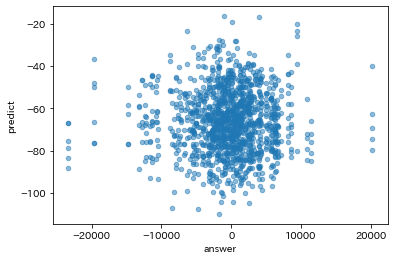

In [23]:
result_df.plot.scatter(x='answer', y='predict', alpha=0.5)